In [26]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import time

import json

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    # Spliting the data by match instead of merging all the entries in a single list like before
    old_raw_data = []
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data.append( [{**el, "match_ts": match_ts} for el in match_data["data"]] )

In [4]:
len(old_raw_data)

20

In [5]:
d = old_raw_data[0][-1]

In [6]:
# 1) For every mission, get defender winrate (mission y, winrate x) and plot as hbar, vertical red line at 0.5
# 2) For every mission, get "defenders' total xp / attacker total xp" and plot as mean +- std between matches (mission y, ratio x), vertical red line at 1
# 3) For every mission, get "(defenders' kills / defenders' deaths) / (same for attackers)", plot as mean +- std between matches (mission y, ratio x), vertical red line at 1
# 4) For every mission, get match duration, plot as boxplots (mission y, duration x)

## 1) For every mission, get defender winrate (mission y, winrate x) and plot as hbar, vertical red line at 0.5

In [61]:
def split_team_info(str):
    alliance = ""
    goal = ""
    
    # Get usefull elements from team info
    values = str.split("\"")[1::2]
    for i in range (0, len(values)):
        if (values[i] == "factionNames"):
            i = i + 1
            for i in range (i, len(values)):
                if (values[i] != "strength"):
                    alliance += (values[i])
                else:
                    break

        if (values[i] == "goal"):
            i = i + 1
            goal = values[i]
    
    return alliance, goal

In [95]:
# Get missions played to the end
missions = {}
for match in old_raw_data:
    # Get the last entry of the match (closing entry aka result)
    end_entry = match[-1]
    # print(end_entry["mission"], end_entry["winner"])

    # Get winner and teams
    winner = split_team_info(end_entry["winner"])
    # Was a winner found? (if not match closed before its end, ignore entry)
    if (winner[1] != ""):        
        t1 = split_team_info(end_entry["t1"])
        t2 = split_team_info(end_entry["t2"])
    
        
        if (not(end_entry["mission"] in missions.keys())):
            missions[end_entry["mission"]] = {}
        
        if (t1[1] == "Defender"):
            if (winner[0] == t1[0]):
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], 1])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], 1]]
            else:
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], 0])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], 0]]
        # Either t2 is Defender or the map is symetric
        # Warning, a symmetric map will thus be randomly assigned a "Defender"
        else:
            if (winner[0] == t2[0]):
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], 1])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], 1]]
            else:
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], 0])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], 0]]

In [96]:
# missions

{'B_GM_Supremacy_Cycladon_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines', 0],
   ['LoyalSpaceMarines', 1],
   ['LoyalSpaceMarines', 1],
   ['LoyalSpaceMarines', 1],
   ['LoyalSpaceMarines', 0],
   ['LoyalSpaceMarines', 1],
   ['LoyalSpaceMarines', 0]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 1],
   ['ChaosSpaceMarines', 1],
   ['ChaosSpaceMarines', 1]]},
 'B_GM_HoldTheLine_Railgate_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0]]},
 'B_GM_Supremacy_Olipsis_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines', 1],
   ['LoyalSpaceMarines', 1]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 0]]},
 'B_GM_MasterDeepStrike_ZedekSmall_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0]]},
 'B_GM_MasterBoardingAction_MaccragesFury_C': {'LoyalSpaceMarines': [['ChaosSpaceMarines',
    1]]}}

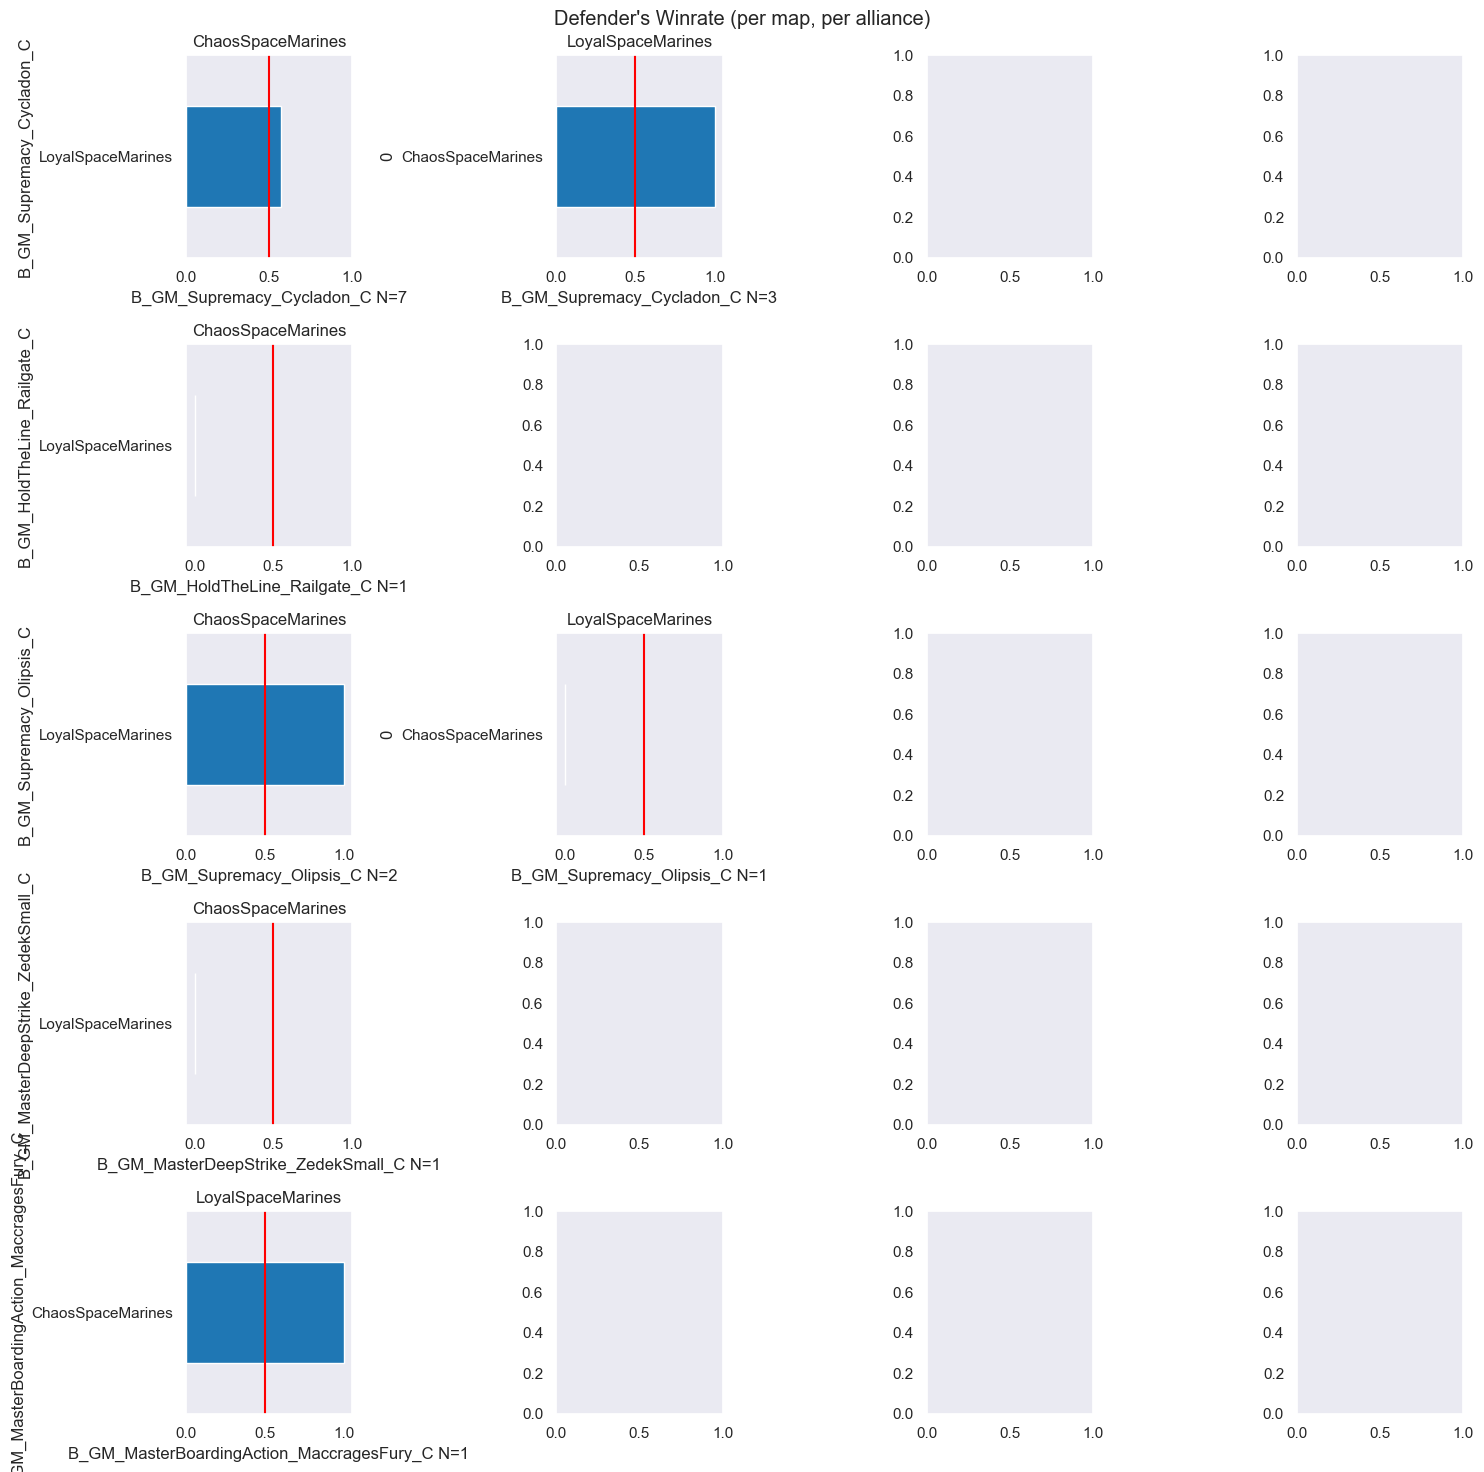

In [175]:
# Plot winrate
keys = missions.keys()
fig, axes = plt.subplots(len(keys), 4, figsize=(15, 15))
fig.suptitle("Defender's Winrate (per map, per alliance)")

for i, key in enumerate(missions.keys()):
    mission = missions[key]
    for j, subkey in enumerate(mission.keys()):
        df = pd.DataFrame(data=mission[subkey]).groupby(0).agg(
            winrate=(1, 'mean')
        )
        df.plot(kind='barh', ax=axes[i,j], xticks=[0, 0.5, 1])
        axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
        axes[i,j].set_title(subkey)
        axes[i,j].axvline(x=0.5, color='red')
        axes[i,j].get_legend().remove()
    axes[i,0].set_ylabel(key)

fig.tight_layout()

In [168]:
split_team_info(d["t1"])

('LoyalSpaceMarines', 'Attacker')

In [40]:
(d["t1"].split("\""))

['{\r\n\t',
 'alliance',
 ':\r\n\t{\r\n\t\t',
 'factionNames',
 ': [\r\n\t\t\t',
 'LoyalSpaceMarines',
 '\r\n\t\t],\r\n\t\t',
 'strength',
 ': 6\r\n\t},\r\n\t',
 'score',
 ': 10000,\r\n\t',
 'maxScore',
 ': 10000,\r\n\t',
 'goal',
 ': ',
 'Attacker',
 ',\r\n\t',
 'spawnsLimited',
 ': false\r\n}']

## 2) For every mission, get "defenders' total xp / attacker total xp" and plot as mean +- std between matches (mission y, ratio x), vertical red line at 1

In [84]:
for i in range(0, 10):
    print(old_raw_data[i][-2])

{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T14-21-47.813736'}
{'faction': 'LSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T16-05-20.750330'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T18-16-00.784233'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T18-58-40.952859'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-21-46.891769'}
{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-34-43.514643'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-57-18.815362'}
{'faction': 'LSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T20-20-31.494811'}
{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T21-35-40.741946'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-06T21-31-15.962131'}


In [88]:
def get_side_xp(match, faction):
    sum = 0
    for e in match:
        if ((e["Type"] == "XP") and (e["tf"] == faction)):
            sum += int(e["value"])
    return sum

In [106]:
missions = {}
for match in old_raw_data:
    # Get the last entry of the match (closing entry aka result)
    end_entry = match[-1]
    # print(end_entry["mission"], end_entry["winner"])

    # Get winner and teams
    winner = split_team_info(end_entry["winner"])
    # Was a winner found? (if not match closed before its end, ignore entry)
    if (winner[1] != ""):        
        t1 = split_team_info(end_entry["t1"])
        t2 = split_team_info(end_entry["t2"])

        # Calculate side XP
        resultA = match[-2]
        resultB = match[-3]
        xpA = get_side_xp(match, resultA["faction"])
        xpB = get_side_xp(match, resultB["faction"])
        
        if (not(end_entry["mission"] in missions.keys())):
            missions[end_entry["mission"]] = {}
        
        if (t1[1] == "Defender"):
            if (winner[0] == t1[0]):
                if (resultA["result"] == "won"):
                    ratio = xpA/xpB
                else:
                    ratio = xpB/xpA
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], ratio])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], ratio]]
            else:
                if (resultA["result"] == "won"):
                    ratio = xpB/xpA
                else:
                    ratio = xpA/xpB
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], ratio])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], ratio]]
        # Either t2 is Defender or the map is symetric
        # Warning, a symmetric map will thus be randomly assigned a "Defender"
        else:
            if (winner[0] == t2[0]):
                if (resultA["result"] == "won"):
                    ratio = xpA/xpB
                else:
                    ratio = xpB/xpA
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], ratio])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], ratio]]
            else:
                if (resultA["result"] == "won"):
                    ratio = xpB/xpA
                else:
                    ratio = xpA/xpB
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], ratio])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], ratio]]

In [94]:
# missions

{'B_GM_Supremacy_Cycladon_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.5176375878220141],
   ['LoyalSpaceMarines', 2.557398289712361],
   ['LoyalSpaceMarines', 2.275816326530612],
   ['LoyalSpaceMarines', 0.6829103161607255],
   ['LoyalSpaceMarines', 0.3338089171974522],
   ['LoyalSpaceMarines', 0.7360985191900876],
   ['LoyalSpaceMarines', 0.37795218105493705]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 0.35809825280079444],
   ['ChaosSpaceMarines', 0.7282492369891791],
   ['ChaosSpaceMarines', 1.0336054780089545]]},
 'B_GM_HoldTheLine_Railgate_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.2667578659370725]]},
 'B_GM_Supremacy_Olipsis_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.585283053491146],
   ['LoyalSpaceMarines', 1.49586814801212]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 0.8503478165859344]]},
 'B_GM_MasterDeepStrike_ZedekSmall_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.9495614035087719]]},
 'B_GM_MasterBoardingAction_Maccrag

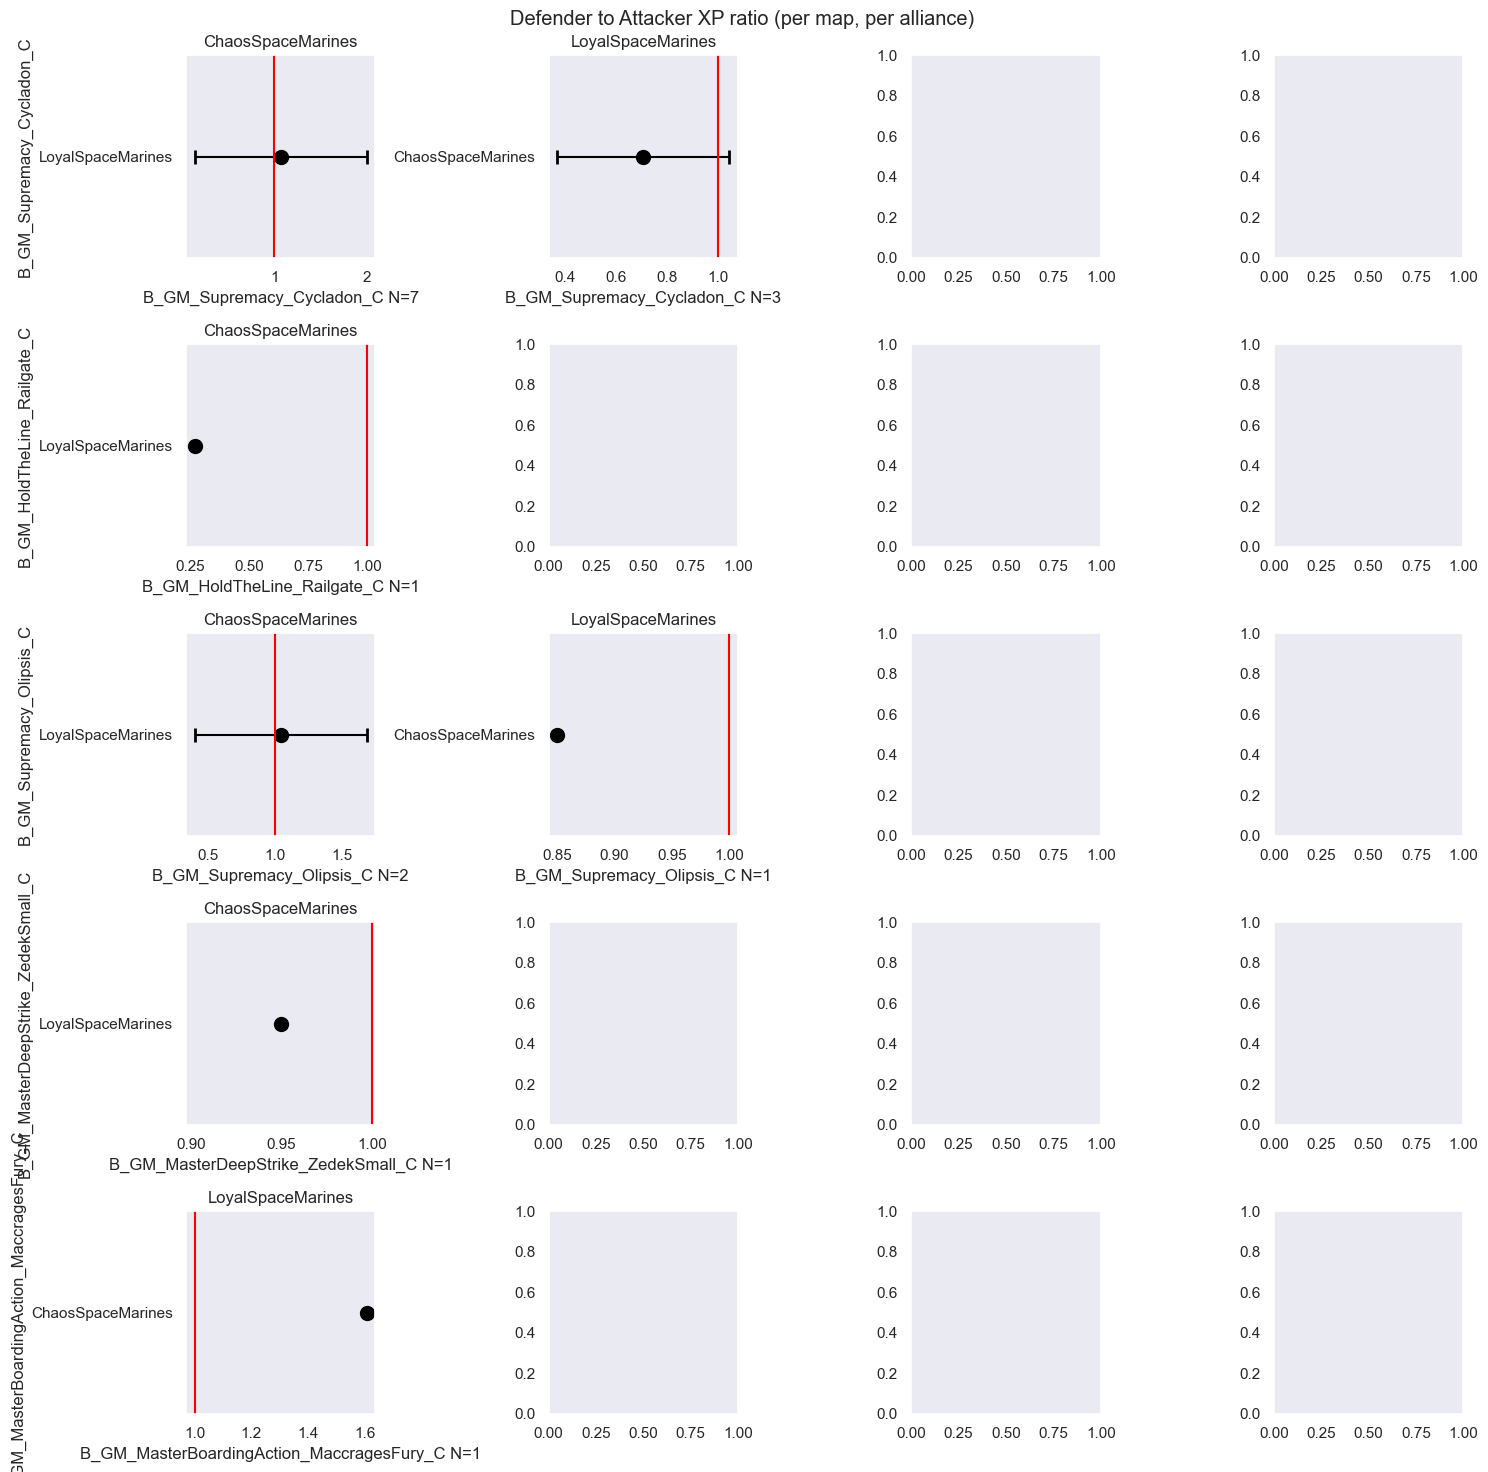

In [104]:
# Plot
keys = missions.keys()
fig, axes = plt.subplots(len(keys), 4, figsize=(15, 15))
fig.suptitle("Defender to Attacker XP ratio (per map, per alliance)")

for i, key in enumerate(missions.keys()):
    mission = missions[key]
    for j, subkey in enumerate(mission.keys()):
        df = pd.DataFrame(data=mission[subkey])
        grouped = df.groupby(0)[1]
        means = grouped.mean()
        stds = grouped.std()
        #df.plot(kind='barh', ax=axes[i,j], xticks=[0, 0.5, 1])
        axes[i,j].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
        for k, (mean_val, std_val) in enumerate(zip(means, stds)):
            axes[i,j].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        #axes[i,j].xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
        axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
        axes[i,j].set_title(subkey)
        axes[i,j].axvline(x=1.0, color='red')
        #axes[i,j].get_legend().remove()
    axes[i,0].set_ylabel(key)

fig.tight_layout()

## 3) For every mission, get "(defenders' kills / defenders' deaths) / (same for attackers)", plot as mean +- std between matches (mission y, ratio x), vertical red line at 1

In [107]:
# Calculates the kill to death ratio of factionA over factionB in a match
def get_side_kd(match, factionA, factionB):
    sumA = 0
    sumB = 0
    for e in match:
        if ((e["Type"] == "XP") and (e["action"] == "Enemy down")):
            if (e["tf"] == factionA):
                sumA += int(e["value"])
            else:
                sumB += int(e["value"])
    return sumA/sumB

In [108]:
missions = {}
for match in old_raw_data:
    # Get the last entry of the match (closing entry aka result)
    end_entry = match[-1]
    # print(end_entry["mission"], end_entry["winner"])

    # Get winner and teams
    winner = split_team_info(end_entry["winner"])
    # Was a winner found? (if not match closed before its end, ignore entry)
    if (winner[1] != ""):        
        t1 = split_team_info(end_entry["t1"])
        t2 = split_team_info(end_entry["t2"])

        # Calculate side kd
        resultA = match[-2]
        resultB = match[-3]
        kdA = get_side_kd(match, resultA["faction"], resultB["faction"])
        
        if (not(end_entry["mission"] in missions.keys())):
            missions[end_entry["mission"]] = {}
        
        if (t1[1] == "Defender"):
            if (winner[0] == t1[0]):
                if (resultA["result"] == "won"):
                    kd = kdA
                else:
                    kd = 1/kdA
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], kd])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], kd]]
            else:
                if (resultA["result"] == "won"):
                    kd = 1/kdA
                else:
                    kd = kdA
                if (t1[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t1[0]].append([t2[0], kd])
                else:
                    missions[end_entry["mission"]][t1[0]] = [[t2[0], kd]]
        # Either t2 is Defender or the map is symetric
        # Warning, a symmetric map will thus be randomly assigned a "Defender"
        else:
            if (winner[0] == t2[0]):
                if (resultA["result"] == "won"):
                    kd = kdA
                else:
                    kd = 1/kdA
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], kd])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], kd]]
            else:
                if (resultA["result"] == "won"):
                    kd = 1/kdA
                else:
                    kd = kdA
                if (t2[0] in missions[end_entry["mission"]].keys()):
                    missions[end_entry["mission"]][t2[0]].append([t1[0], kd])
                else:
                    missions[end_entry["mission"]][t2[0]] = [[t1[0], kd]]

In [109]:
# missions

{'B_GM_Supremacy_Cycladon_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    1.1176470588235294],
   ['LoyalSpaceMarines', 1.0526315789473684],
   ['LoyalSpaceMarines', 1.0208333333333333],
   ['LoyalSpaceMarines', 1.2063492063492063],
   ['LoyalSpaceMarines', 0.7142857142857143],
   ['LoyalSpaceMarines', 0.6065573770491803],
   ['LoyalSpaceMarines', 0.6585365853658537]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 0.7058823529411765],
   ['ChaosSpaceMarines', 0.72],
   ['ChaosSpaceMarines', 0.85]]},
 'B_GM_HoldTheLine_Railgate_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.6065573770491803]]},
 'B_GM_Supremacy_Olipsis_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.7285714285714285],
   ['LoyalSpaceMarines', 1.588235294117647]],
  'LoyalSpaceMarines': [['ChaosSpaceMarines', 1.2666666666666666]]},
 'B_GM_MasterDeepStrike_ZedekSmall_C': {'ChaosSpaceMarines': [['LoyalSpaceMarines',
    0.75]]},
 'B_GM_MasterBoardingAction_MaccragesFury_C': {'LoyalSpaceMarines': [['Chao

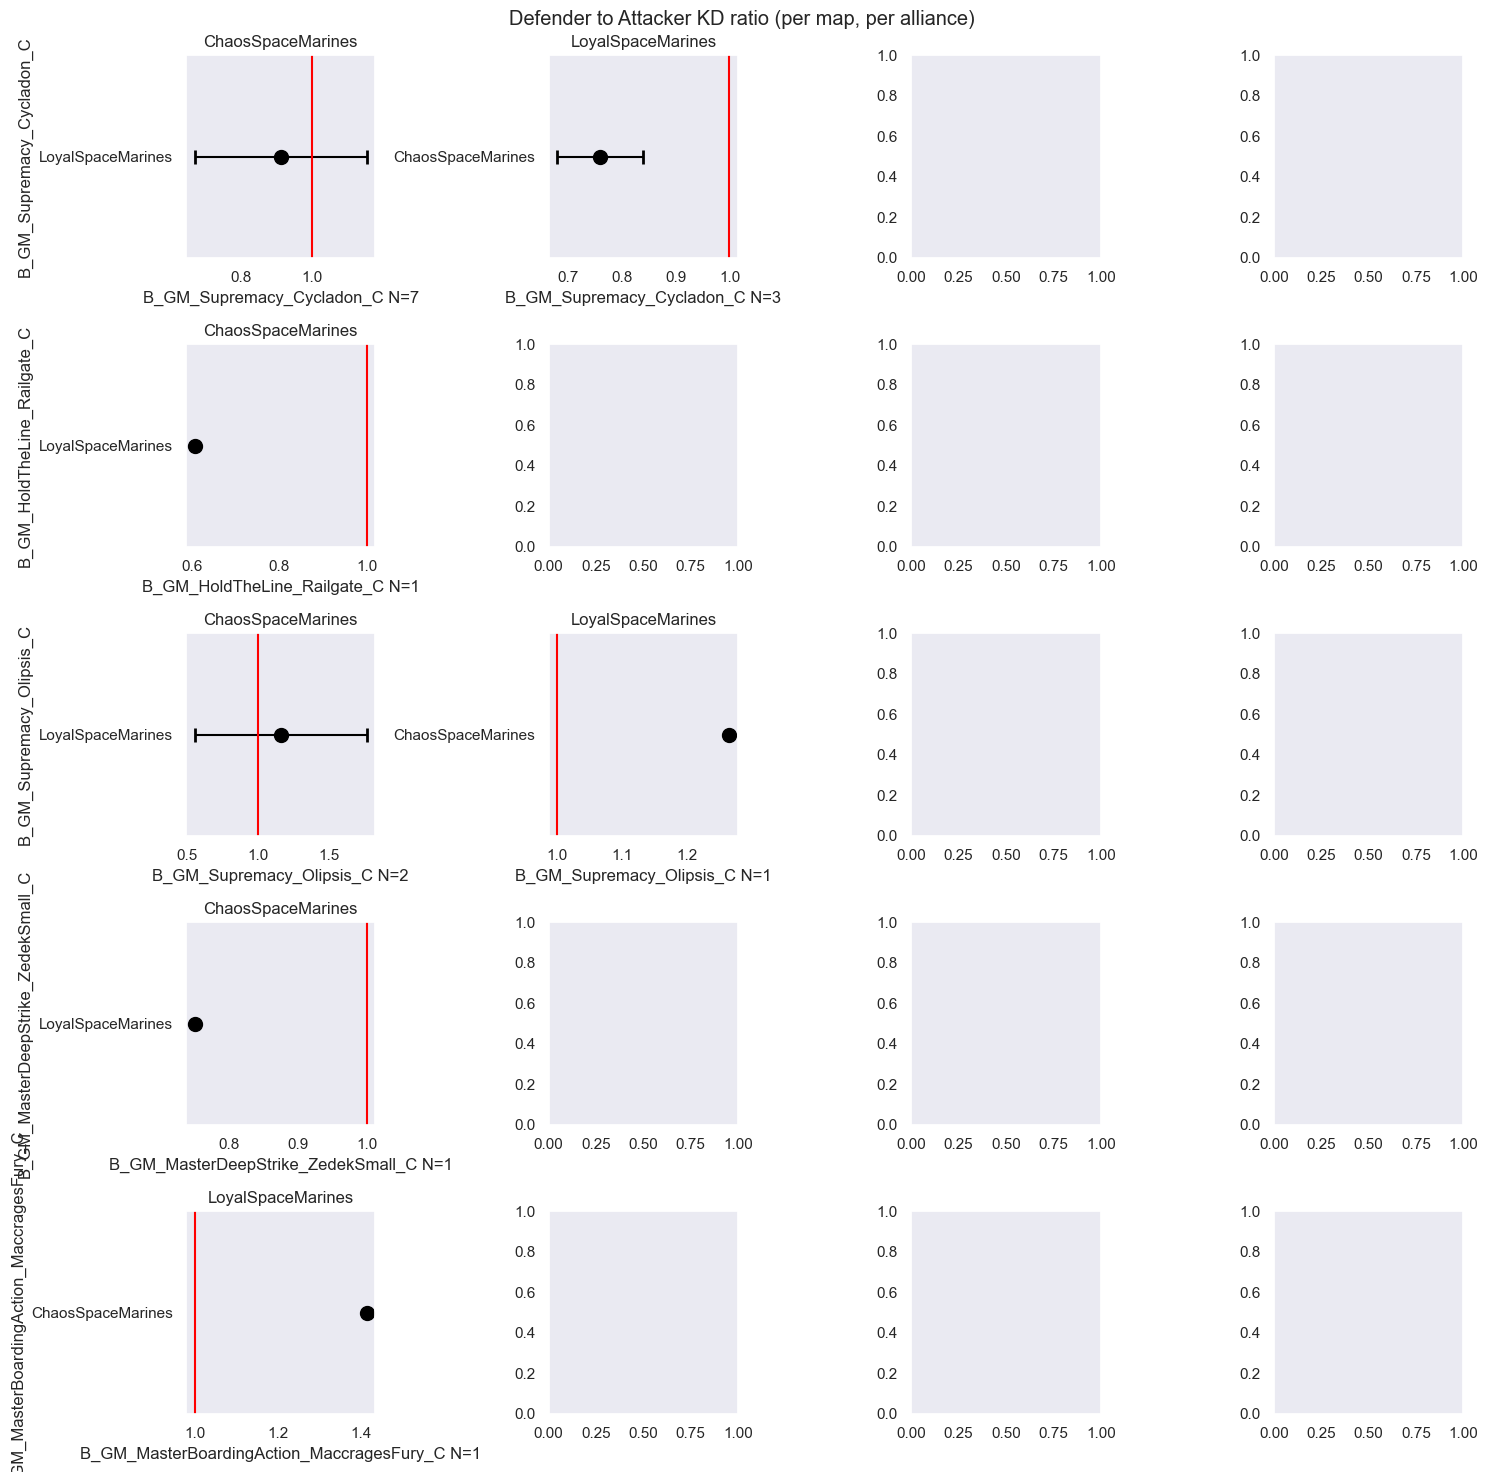

In [110]:
# Plot
keys = missions.keys()
fig, axes = plt.subplots(len(keys), 4, figsize=(15, 15))
fig.suptitle("Defender to Attacker KD ratio (per map, per alliance)")

for i, key in enumerate(missions.keys()):
    mission = missions[key]
    for j, subkey in enumerate(mission.keys()):
        df = pd.DataFrame(data=mission[subkey])
        grouped = df.groupby(0)[1]
        means = grouped.mean()
        stds = grouped.std()
        #df.plot(kind='barh', ax=axes[i,j], xticks=[0, 0.5, 1])
        axes[i,j].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
        for k, (mean_val, std_val) in enumerate(zip(means, stds)):
            axes[i,j].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        #axes[i,j].xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
        axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
        axes[i,j].set_title(subkey)
        axes[i,j].axvline(x=1.0, color='red')
        #axes[i,j].get_legend().remove()
    axes[i,0].set_ylabel(key)

fig.tight_layout()

## 4) For every mission, get match duration, plot as boxplots (mission y, duration x)

In [79]:
old_raw_data[15][-1]

{'faction': 'CSM',
 'result': 'lost',
 'Type': 'WonLost',
 'match_ts': '2023-09-06T21-52-50.428080'}

In [54]:
old_raw_data[15][0]

{'map': 'CycladonComplex',
 'mission': 'B_GM_Supremacy_Cycladon_C',
 'a1': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"ChaosSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 0,\r\n\t"maxScore": 10000,\r\n\t"goal": "Attacker",\r\n\t"spawnsLimited": false\r\n}',
 'a2': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 0,\r\n\t"maxScore": 10000,\r\n\t"goal": "Defender",\r\n\t"spawnsLimited": true\r\n}',
 'a3': '',
 'a4': '',
 'pa': '',
 'Type': 'MatchStart',
 'match_ts': '2023-09-08T18-24-22.324624'}

In [57]:
missions
# 'duration': '1693923949.287'
# 1693929915.893
# 1693937725.18
# 1694037162.428
time.gmtime(1694197458.4)

time.struct_time(tm_year=2023, tm_mon=9, tm_mday=8, tm_hour=18, tm_min=24, tm_sec=18, tm_wday=4, tm_yday=251, tm_isdst=0)

In [62]:
# Get missions played to the end
missions = {}
for match in old_raw_data:
    # Get the last entry of the match (closing entry aka result)
    end_entry = match[-1]
    # print(end_entry["mission"], end_entry["winner"])

    # Get winner
    winner = split_team_info(end_entry["winner"])
    # Was a winner found? (if not match closed before its end, ignore entry)
    if (winner[1] != ""):        
        pass
        